# Lab 7
#### Working with low pT particle collision data from the Large Hadron Collider. 

In [94]:
import pickle 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
%matplotlib inline 
import pandas as pd

In [95]:
qcd_file = pd.read_pickle(r'Data/qcd_100000_pt_250_500.pkl')
bkgd=pd.DataFrame(qcd_file, columns=['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1', 't2', 't3', 't21', 't32', 'KtDeltaR'])
bkgd.head(2)

,pt,eta,phi,mass,ee2,ee3,d2,angularity,t1,t2,t3,t21,t32,KtDeltaR
0,489.631389,1.955969,1.803007,125.298720,0.099409,0.003247,3.304886,0.000528,0.846096,0.586658,0.439468,0.693370,0.749105,0.333731
1,401.041884,-1.170413,0.188817,88.047054,0.101181,0.002527,2.439089,0.001561,0.852379,0.517657,0.336052,0.607308,0.649178,0.477481


In [96]:
signal_file = pd.read_pickle(r'Data/higgs_100000_pt_250_500.pkl')
higgs=pd.DataFrame(signal_file, columns=['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1', 't2', 't3', 't21', 't32', 'KtDeltaR'])
higgs.head(2)
bkgd=pd.DataFrame(qcd_file, columns=['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1', 't2', 't3', 't21', 't32', 'KtDeltaR'])
bkgd.head(2)

,pt,eta,phi,mass,ee2,ee3,d2,angularity,t1,t2,t3,t21,t32,KtDeltaR
0,489.631389,1.955969,1.803007,125.298720,0.099409,0.003247,3.304886,0.000528,0.846096,0.586658,0.439468,0.693370,0.749105,0.333731
1,401.041884,-1.170413,0.188817,88.047054,0.101181,0.002527,2.439089,0.001561,0.852379,0.517657,0.336052,0.607308,0.649178,0.477481


## 1)

Make a stacked histogram plot for the feature variable: mass <br>
 >Evaluate expected significance without any event selection.<br>
a) Use Poisson statistics for significance calculation <br>
b) Compare the exact significance to the approximation  NHiggs/(√NQCD) . If they are equivalent, explain your findings.

<b> Answer </b> <br>

<u> Statistical Question </u> : What is the probability that background of 20,000  particles gives a measurement equal to or greater than 20,000+100 particles?

I will simulate a Poisson with mean 20,000 (qcd yield) and find the significance of a 20,000+100 observation.

In [97]:
yield_higgs,yield_bkgd=100,20000

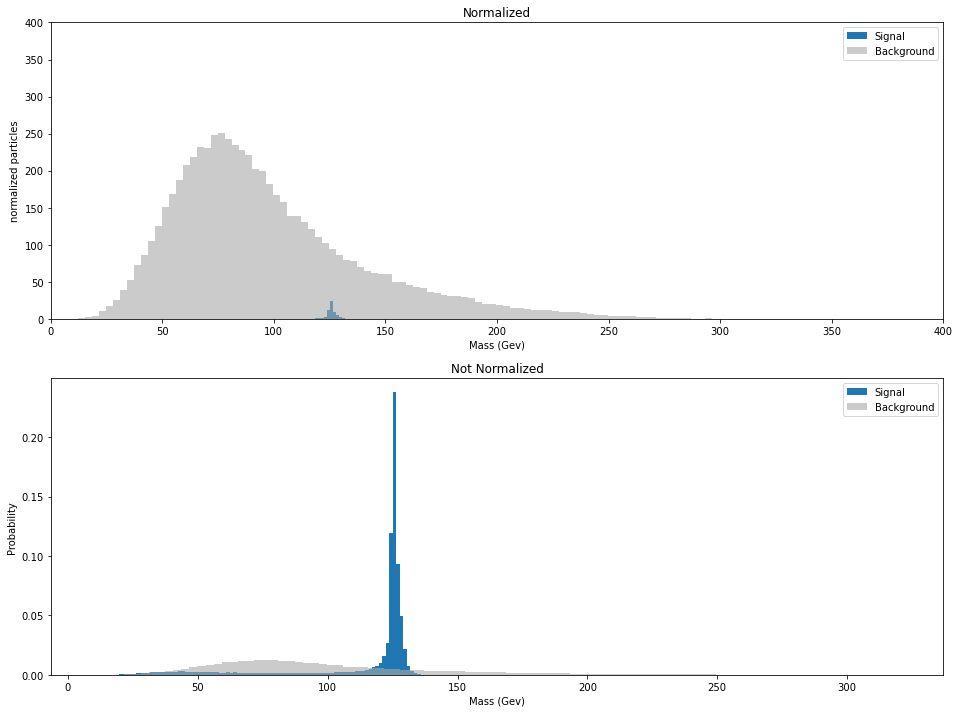

In [98]:
fig,(ax,ax1)=plt.subplots(2,1,figsize=(16,12))
hh,bh,_1=ax.hist(higgs["mass"],bins=100,density=True,label="Signal",alpha=1)
for r in _1:
    r.set_height(r.get_height()*yield_higgs)

hq,bq,_2=ax.hist(bkgd["mass"],bins=100,density=True,label="Background",color="darkgray",alpha=.6)
for r2 in _2:
    r2.set_height(r2.get_height()*yield_bkgd)
    

ax.legend()
ax.set_xlim(0,400)
ax.set_xlabel("Mass (Gev)")
ax.set_ylim(0,400)
ax.set_ylabel("normalized particles")

hh,bh,_1=ax1.hist(higgs["mass"],bins=100,density=True,label="Signal",alpha=1)
hq,bq,_2=ax1.hist(bkgd["mass"],bins=100,density=True,label="Background",color="darkgray",alpha=.6)

ax1.set_xlabel("Mass (Gev)")
ax1.set_ylabel("Probability")
ax.set_title("Normalized")
ax1.set_title("Not Normalized")
ax1.legend()

In [99]:
from scipy.stats import poisson
from scipy.stats import norm

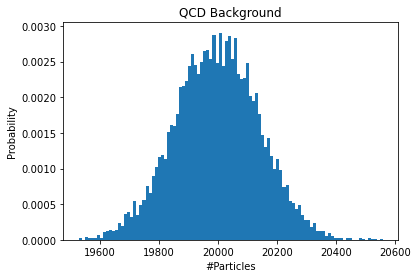

In [100]:
mu=20000
s = np.random.poisson(mu, 10000)
plt.hist(s,bins=100,density=True)
plt.title("QCD Background")
plt.xlabel("#Particles")
plt.ylabel("Probability")
plt.show()

In [101]:
x=20000+100
prob=poisson.cdf(x,mu=mu)
sigma=norm.ppf(prob) 
print ("Exact Significance: ", sigma)

Exact Significance:  0.7112259282313185


In [102]:
from math import sqrt
approx=yield_higgs/sqrt(yield_bkgd)
print ("Theoretical Significance: ", approx)

Theoretical Significance:  0.7071067811865475


In [103]:
((sigma-approx)/sigma)*100

0.5791615408361915

The deviation between the two numbers is ~0.6% which means the significances are <u> approximately equal </u>. We're basically trying to show how likely are we to count 20100 particles from a data that shoule have a mean at 20000. The sqrt(N_QCD) gives the width of the QCD poisson distribution or the 1 sigma point. So the N_higgs/sqrt(N_QCD) ratio gives the # standard deviations (or sigmas) that would give a measurement of 20100 particles. 

### 2)

As seen from the graph above, Higgs mass lies mostly between 100 and 150. I will try to make cuts to maximize the signal to noise ratio (SNR) to increase significance. 

Since the higgs distribution is roughly symmetric about its center, I will start with narrow cuts symmetric about the higgs mass maxima and systematically widen my "window" in order to retain as much signal as possible without compromising on the significance. 
Formula used : 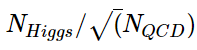

In [104]:
from math import sqrt

In [105]:
mu_bkgd=bq[np.argmax(hq)]
mu_higgs=bh[np.argmax(hh)]
mu_higgs,mu_bkgd

(125.088717033452, 74.834904265888)

In [106]:
mass_ranges=[[123,126],[123,127],[123,129],[123,130],[123,133],[122,126],[122,127],[122,129],[122,130],[120,130],[121,130],[121,128],[118,132],[114,136],[110,140],[106,144],[100,150],[94,156]]
sigs=[]
for i in range (len(mass_ranges)):
    higgs_cut=higgs.query(f'{mass_ranges[i][1]}>mass>{mass_ranges[i][0]}') #higgs bw bounds
    bkgd_cut=bkgd.query(f'{mass_ranges[i][1]}>mass>{mass_ranges[i][0]}')   #bkgd bw bounds
    significance=(len(higgs_cut)*yield_higgs/len(higgs))/(sqrt(len(bkgd_cut)*yield_bkgd/len(higgs))) 
    sigs.append(significance)
print( "Mass range",mass_ranges[np.argmax(sigs)], " give maximum significance = ",max(sigs))

Mass range [123, 129]  give maximum significance =  2.8826565935900543


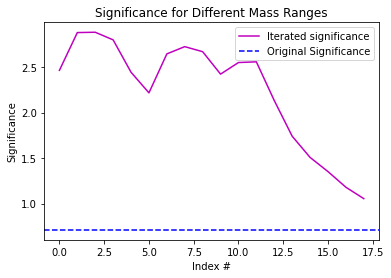

In [107]:
index=np.arange(0,len(mass_ranges),1)
plt.plot(index,sigs,c="m",label="Iterated significance")
plt.xlabel("Index #");plt.ylabel("Significance");plt.title("Significance for Different Mass Ranges")
plt.axhline(sigma,ls="--",c="b",label="Original Significance")
plt.legend()

Maximum significance obtained is ~2.8 with mass range [123,130].

### 3) 

Make two sets of stacked histogram plots for the rest of the features
Set A without any event selection. <br>
Can you identify another feature as discriminative as mass? (i.e. equal or better significance after feature cut)<br>

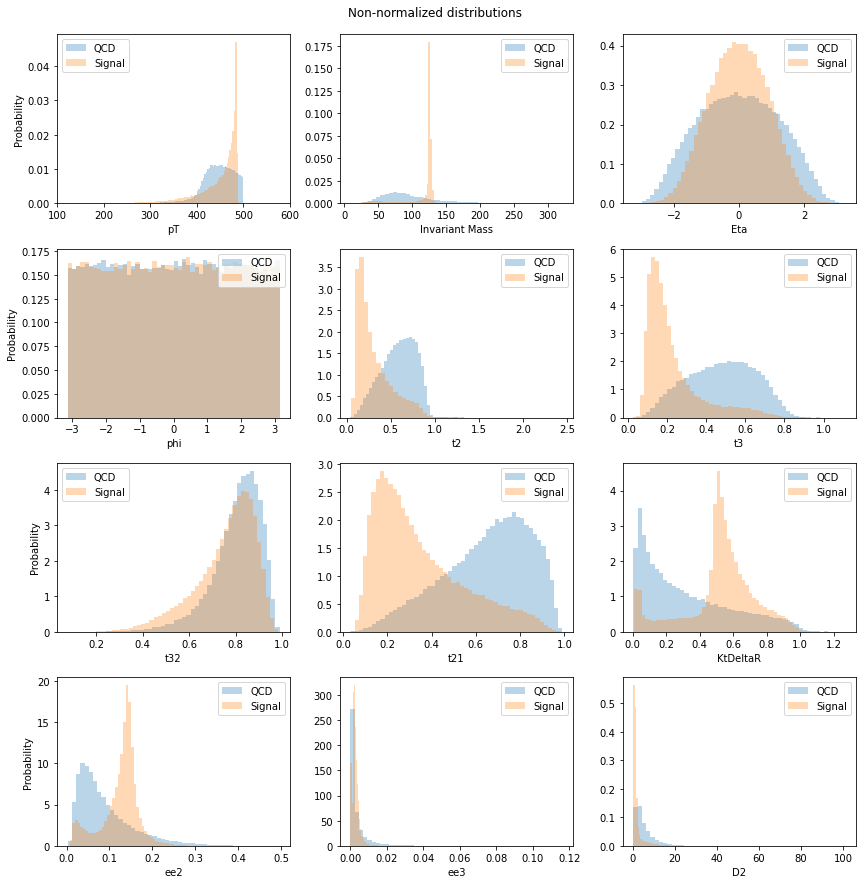

In [108]:
fig,((ax,ax1,ax2),(ax3,ax4,ax5),(ax6,ax7,ax8),(ax9,ax10,ax11))=plt.subplots(4,3,figsize=(12,12))

ax.hist(bkgd["pt"],bins=80,alpha=0.3,density=True,label="QCD")
ax.hist(higgs["pt"],bins=80,alpha=0.3,density=True,label="Signal")
ax.set_ylabel("Probability")
ax.set_xlabel("pT")
ax.set_xlim(100,600)

ax1.hist(bkgd["mass"],bins=50,alpha=0.3,density=True,label="QCD")
ax1.hist(higgs["mass"],bins=50,alpha=0.3,density=True,label="Signal")
ax.set_ylabel("Probability")
ax1.set_xlabel("Invariant Mass")

ax2.hist(bkgd["eta"],bins=50,alpha=0.3,density=True,label="QCD")
ax2.hist(higgs["eta"],bins=50,alpha=0.3,density=True,label="Signal")
ax.set_ylabel("Probability")
ax2.set_xlabel("Eta")

ax3.hist(bkgd["phi"],bins=50,alpha=0.3,density=True,label="QCD")
ax3.hist(higgs["phi"],bins=50,alpha=0.3,density=True,label="Signal")
ax3.set_ylabel("Probability")
ax3.set_xlabel("phi")

ax4.hist(bkgd["t2"],bins=50,alpha=0.3,density=True,label="QCD")
ax4.hist(higgs["t2"],bins=50,alpha=0.3,density=True,label="Signal")
ax.set_ylabel("Probability")
ax4.set_xlabel("t2")

ax5.hist(bkgd["t3"],bins=50,alpha=0.3,density=True,label="QCD")
ax5.hist(higgs["t3"],bins=50,alpha=0.3,density=True,label="Signal")
ax6.set_ylabel("Probability")
ax5.set_xlabel("t3")

ax6.hist(bkgd["t32"],bins=50,alpha=0.3,density=True,label="QCD")
ax6.hist(higgs["t32"],bins=50,alpha=0.3,density=True,label="Signal")
ax.set_ylabel("Probability")
ax6.set_xlabel("t32")

ax7.hist(bkgd["t21"],bins=50,alpha=0.3,density=True,label="QCD")
ax7.hist(higgs["t21"],bins=50,alpha=0.3,density=True,label="Signal")
ax.set_ylabel("Probability")
ax7.set_xlabel("t21")

ax8.hist(bkgd["KtDeltaR"],bins=50,alpha=0.3,density=True,label="QCD")
ax8.hist(higgs["KtDeltaR"],bins=50,alpha=0.3,density=True,label="Signal")
ax.set_ylabel("Probability")
ax8.set_xlabel("KtDeltaR")

ax9.hist(bkgd["ee2"],bins=50,alpha=0.3,density=True,label="QCD")
ax9.hist(higgs["ee2"],bins=50,alpha=0.3,density=True,label="Signal")
ax.set_ylabel("Probability")
ax9.set_xlabel("ee2")

ax10.hist(bkgd["ee3"],bins=50,alpha=0.3,density=True,label="QCD")
ax10.hist(higgs["ee3"],bins=50,alpha=0.3,density=True,label="Signal")
ax9.set_ylabel("Probability")
ax10.set_xlabel("ee3")

ax11.hist(bkgd["d2"],alpha=0.3,bins=50,density=True,label="QCD")
ax11.hist(higgs["d2"],alpha=0.3,bins=50,density=True,label="Signal")
ax.set_ylabel("Probability")
ax11.set_xlabel("D2")

plt.tight_layout();ax.legend();ax1.legend();ax2.legend();ax3.legend();ax4.legend();
ax5.legend();ax6.legend();ax7.legend();ax8.legend();ax9.legend();ax10.legend();ax11.legend()
fig.suptitle("Non-normalized distributions",y=1.02)
plt.show()

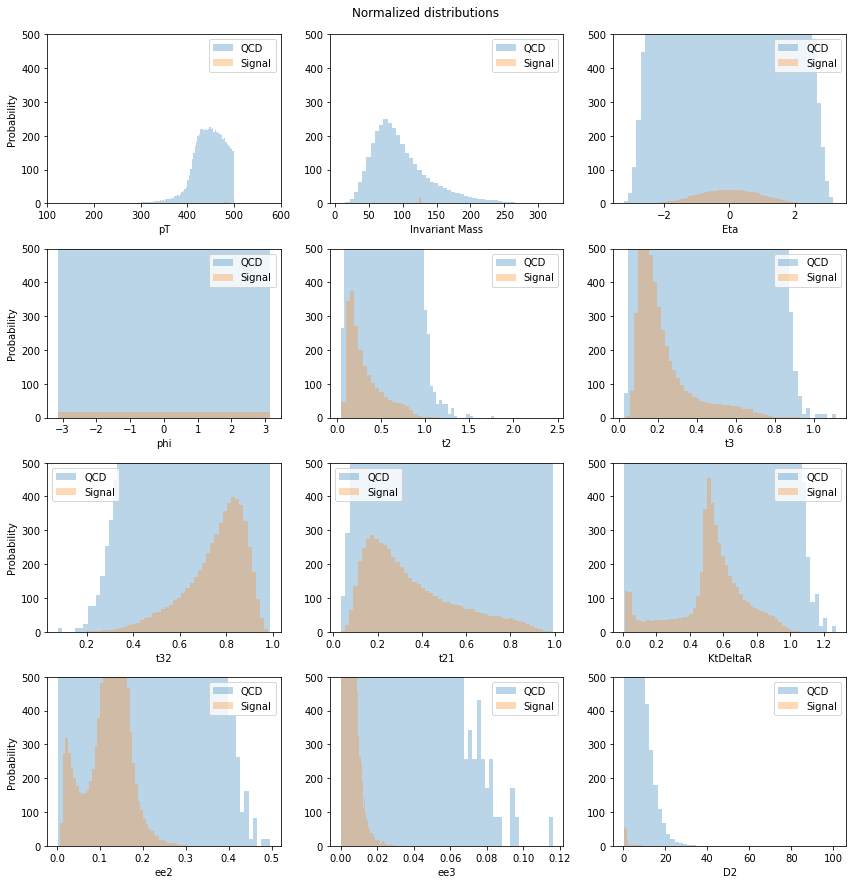

In [109]:
fig,((ax,ax1,ax2),(ax3,ax4,ax5),(ax6,ax7,ax8),(ax9,ax10,ax11))=plt.subplots(4,3,figsize=(12,12))

hh,bh,_1=ax.hist(bkgd["pt"],bins=80,alpha=0.3,density=True,label="QCD")
for r in _1:
    r.set_height(r.get_height()*yield_bkgd)
hh,bh,_1=ax.hist(higgs["pt"],bins=80,alpha=0.3,density=True,label="Signal")
for r in _1:
    r.set_height(r.get_height()*yield_higgs)

ax.set_ylabel("Probability")
ax.set_xlabel("pT")
ax.set_xlim(100,600)

hh,bh,_1=ax1.hist(bkgd["mass"],bins=50,alpha=0.3,density=True,label="QCD")
for r in _1:
    r.set_height(r.get_height()*yield_bkgd)
hh,bh,_1=ax1.hist(higgs["mass"],bins=50,alpha=0.3,density=True,label="Signal")
for r in _1:
    r.set_height(r.get_height()*yield_higgs)

ax.set_ylabel("Probability")
ax1.set_xlabel("Invariant Mass")

hh,bh,_1=ax2.hist(bkgd["eta"],bins=50,alpha=0.3,density=True,label="QCD")
for r in _1:
    r.set_height(r.get_height()*yield_bkgd)
hh,bh,_1=ax2.hist(higgs["eta"],bins=50,alpha=0.3,density=True,label="Signal")
for r in _1:
    r.set_height(r.get_height()*yield_higgs)

ax.set_ylabel("Probability")
ax2.set_xlabel("Eta")

hh,bh,_1=ax3.hist(bkgd["phi"],bins=50,alpha=0.3,density=True,label="QCD")
for r in _1:
    r.set_height(r.get_height()*yield_bkgd)
hh,bh,_1=ax3.hist(higgs["phi"],bins=50,alpha=0.3,density=True,label="Signal")
for r in _1:
    r.set_height(r.get_height()*yield_higgs)

ax3.set_ylabel("Probability")
ax3.set_xlabel("phi")

hh,bh,_1=ax4.hist(bkgd["t2"],bins=50,alpha=0.3,density=True,label="QCD")
for r in _1:
    r.set_height(r.get_height()*yield_bkgd)
hh,bh,_1=ax4.hist(higgs["t2"],bins=50,alpha=0.3,density=True,label="Signal")
for r in _1:
    r.set_height(r.get_height()*yield_higgs)

ax.set_ylabel("Probability")
ax4.set_xlabel("t2")

hh,bh,_1=ax5.hist(bkgd["t3"],bins=50,alpha=0.3,density=True,label="QCD")
for r in _1:
    r.set_height(r.get_height()*yield_bkgd)
hh,bh,_1=ax5.hist(higgs["t3"],bins=50,alpha=0.3,density=True,label="Signal")
for r in _1:
    r.set_height(r.get_height()*yield_higgs)

ax6.set_ylabel("Probability")
ax5.set_xlabel("t3")

hh,bh,_1=ax6.hist(bkgd["t32"],bins=50,alpha=0.3,density=True,label="QCD")
for r in _1:
    r.set_height(r.get_height()*yield_bkgd)
hh,bh,_1=ax6.hist(higgs["t32"],bins=50,alpha=0.3,density=True,label="Signal")
for r in _1:
    r.set_height(r.get_height()*yield_higgs)

ax.set_ylabel("Probability")
ax6.set_xlabel("t32")

hh,bh,_1=ax7.hist(bkgd["t21"],bins=50,alpha=0.3,density=True,label="QCD")
for r in _1:
    r.set_height(r.get_height()*yield_bkgd)
hh,bh,_1=ax7.hist(higgs["t21"],bins=50,alpha=0.3,density=True,label="Signal")
for r in _1:
    r.set_height(r.get_height()*yield_higgs)

ax.set_ylabel("Probability")
ax7.set_xlabel("t21")

hh,bh,_1=ax8.hist(bkgd["KtDeltaR"],bins=50,alpha=0.3,density=True,label="QCD")
for r in _1:
    r.set_height(r.get_height()*yield_bkgd)
hh,bh,_1=ax8.hist(higgs["KtDeltaR"],bins=50,alpha=0.3,density=True,label="Signal")
for r in _1:
    r.set_height(r.get_height()*yield_higgs)

ax.set_ylabel("Probability")
ax8.set_xlabel("KtDeltaR")

hh,bh,_1=ax9.hist(bkgd["ee2"],bins=50,alpha=0.3,density=True,label="QCD")
for r in _1:
    r.set_height(r.get_height()*yield_bkgd)
hh,bh,_1=ax9.hist(higgs["ee2"],bins=50,alpha=0.3,density=True,label="Signal")
for r in _1:
    r.set_height(r.get_height()*yield_higgs)

ax.set_ylabel("Probability")
ax9.set_xlabel("ee2")

hh,bh,_1=ax10.hist(bkgd["ee3"],bins=50,alpha=0.3,density=True,label="QCD")
for r in _1:
    r.set_height(r.get_height()*yield_bkgd)
hh,bh,_1=ax10.hist(higgs["ee3"],bins=50,alpha=0.3,density=True,label="Signal")
for r in _1:
    r.set_height(r.get_height()*yield_higgs)

ax9.set_ylabel("Probability")
ax10.set_xlabel("ee3")

hh,bh,_1=ax11.hist(bkgd["d2"],alpha=0.3,bins=50,density=True,label="QCD")
for r in _1:
    r.set_height(r.get_height()*yield_bkgd)

hh,bh,_1=ax11.hist(higgs["d2"],alpha=0.3,bins=50,density=True,label="Signal")
for r in _1:
    r.set_height(r.get_height()*yield_higgs)

ax.set_ylabel("Probability")
ax11.set_xlabel("D2")

plt.tight_layout();ax.legend();ax1.legend();ax2.legend();ax3.legend();ax4.legend();
ax5.legend();ax6.legend();ax7.legend();ax8.legend();ax9.legend();ax10.legend();ax11.legend()

for i in fig.axes:
    i.set_ylim(0,500)
    
fig.suptitle("Normalized distributions",y=1.02)

plt.show()

##### Set A 
KtDeltaR,d2 and t21 appear to be good discriminators since their peaks have large distance between them.

##### t21
>T21 is not symmetric about the peak so the cuts don't have to be symmetric. 

In [110]:
t21_ranges=[[0.19,2.1],[0.18,2.2],[0,2.1],[0.16,0.25],[0.15,0.28],[0.14,0.31],[0.13,0.35],[0.13,0.36],[0.12,0.36],[0.11,0.36],[0.1,0.36],[0,0.38],[0,0.39]]
sigs_t21=[]
for i in range (len(t21_ranges)):
    higgs_cut=higgs.query(f'{t21_ranges[i][1]}>t21>{t21_ranges[i][0]}') #higgs bw bounds
    bkgd_cut=bkgd.query(f'{t21_ranges[i][1]}>t21>{t21_ranges[i][0]}')   #bkgs bw bounds
    significance=(len(higgs_cut)*yield_higgs/len(higgs))/(sqrt(len(bkgd_cut)*yield_bkgd/len(higgs))) 
    sigs_t21.append(significance)
print( "t21 range",t21_ranges[np.argmax(sigs_t21)], " give maximum significance = ",max(sigs_t21))

t21 range [0, 0.38]  give maximum significance =  1.3600731435642037


Max t21 significance is still lower than one obtained after mass cuts. 

Text(0, 0.5, 'Significance')

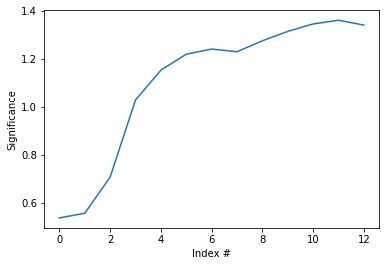

In [111]:
plt.plot(sigs_t21)
plt.xlabel("Index #")
plt.ylabel("Significance")

##### KtDeltaR
>KtDeltaR of signal seems to lie mostly between 0.4 and 0.8 and is assymetric. 

In [112]:
KtDeltaR_ranges=[[0.5,0.7],[0.5,0.75],[0.5,0.8],[0.4,0.8],[0.4,0.88],[0.4,0.9],[0.3,0.8],[0.3,1]]
sigs_KtDeltaR=[]
for i in range (len(KtDeltaR_ranges)):
    higgs_cut=higgs.query(f'{KtDeltaR_ranges[i][1]}>KtDeltaR>{KtDeltaR_ranges[i][0]}') #higgs bw bounds
    bkgd_cut=bkgd.query(f'{KtDeltaR_ranges[i][1]}>KtDeltaR>{KtDeltaR_ranges[i][0]}')   #bkgs bw bounds
    significance=(len(higgs_cut)*yield_higgs/len(higgs))/(sqrt(len(bkgd_cut)*yield_bkgd/len(higgs))) 
    sigs_KtDeltaR.append(significance)
print( "KtDeltaR range",KtDeltaR_ranges[np.argmax(sigs_KtDeltaR)], " give maximum significance = ",max(sigs_KtDeltaR))

KtDeltaR range [0.4, 0.88]  give maximum significance =  1.029241794391712


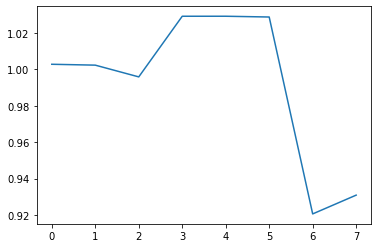

In [113]:
plt.plot(sigs_KtDeltaR)

#### D2

In [115]:
d2_ranges=[[0.5,0.7],[0.5,0.75],[0.5,0.8],[0.4,0.8],[0.4,0.88],[0.4,0.9],[0.3,0.8],[0.3,1]]
sigs_d2=[]
for i in range (len(d2_ranges)):
    higgs_cut=higgs.query(f'{d2_ranges[i][1]}>d2>{d2_ranges[i][0]}') #higgs bw bounds
    bkgd_cut=bkgd.query(f'{d2_ranges[i][1]}>d2>{d2_ranges[i][0]}')   #bkgs bw bounds
    significance=(len(higgs_cut)*yield_higgs/len(higgs))/(sqrt(len(bkgd_cut)*yield_bkgd/len(higgs))) 
    sigs_d2.append(significance)
print( "D2 range",d2_ranges[np.argmax(sigs_d2)], " give maximum significance = ",max(sigs_d2))

D2 range [0.3, 0.8]  give maximum significance =  1.741509143697511


From my analysis, mass seems to provide the most efficient cut. 

### Set B 
With your optimal mass cuts, can you identify another feature to further improve your expected signifiance?

### Set B

In [116]:
higgs=pd.DataFrame(signal_file, columns=['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1', 't2', 't3', 't21', 't32', 'KtDeltaR'])
bkgd=pd.DataFrame(qcd_file, columns=['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1', 't2', 't3', 't21', 't32', 'KtDeltaR'])

In [117]:
higgs_m_cut=higgs.query(f'{130}>mass>{123}')
bkgd_m_cut=bkgd.query(f'{130}>mass>{123}')

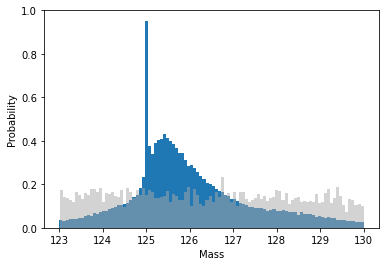

In [118]:
plt.hist(higgs_m_cut["mass"],bins=100,density=True)
plt.hist(bkgd_m_cut["mass"],bins=100,density=True,alpha=0.5,color="darkgray")
plt.xlabel("Mass")
plt.ylabel("Probability")
plt.show()

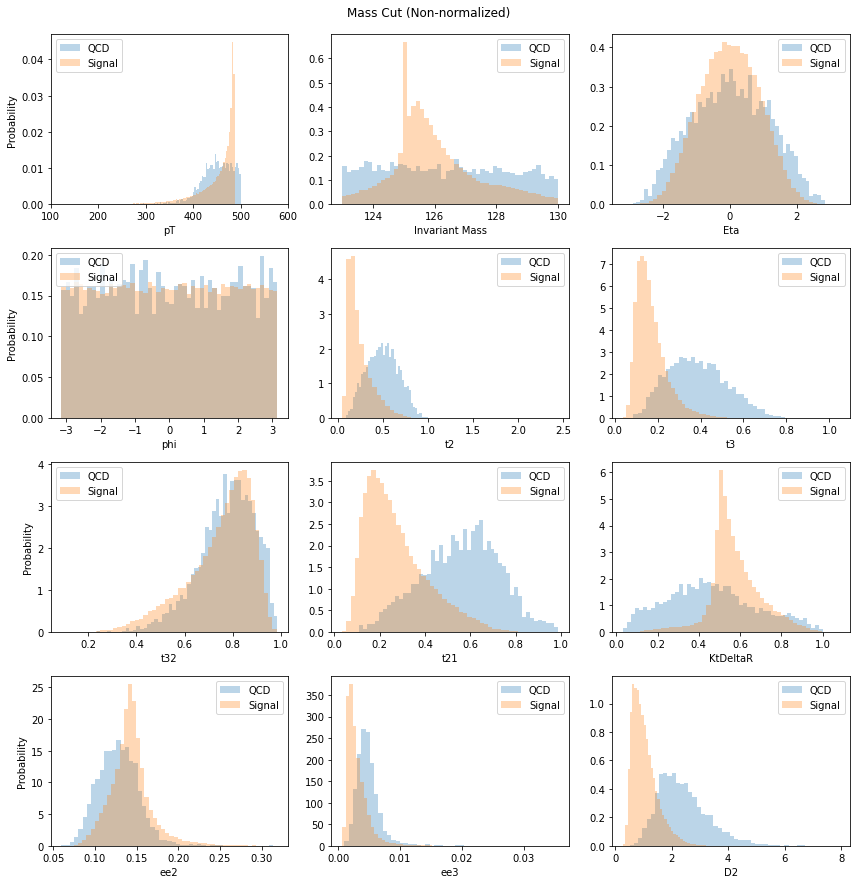

In [119]:
fig,((ax,ax1,ax2),(ax3,ax4,ax5),(ax6,ax7,ax8),(ax9,ax10,ax11))=plt.subplots(4,3,figsize=(12,12))


ax.hist(bkgd_m_cut["pt"],bins=80,alpha=0.3,density=True,label="QCD")
ax.hist(higgs_m_cut["pt"],bins=80,alpha=0.3,density=True,label="Signal")
ax.set_ylabel("Probability")
ax.set_xlabel("pT")
ax.set_xlim(100,600)

ax1.hist(bkgd_m_cut["mass"],bins=50,alpha=0.3,density=True,label="QCD")
ax1.hist(higgs_m_cut["mass"],bins=50,alpha=0.3,density=True,label="Signal")
ax.set_ylabel("Probability")
ax1.set_xlabel("Invariant Mass")

ax2.hist(bkgd_m_cut["eta"],bins=50,alpha=0.3,density=True,label="QCD")
ax2.hist(higgs_m_cut["eta"],bins=50,alpha=0.3,density=True,label="Signal")
ax.set_ylabel("Probability")
ax2.set_xlabel("Eta")

ax3.hist(bkgd_m_cut["phi"],bins=50,alpha=0.3,density=True,label="QCD")
ax3.hist(higgs_m_cut["phi"],bins=50,alpha=0.3,density=True,label="Signal")
ax3.set_ylabel("Probability")
ax3.set_xlabel("phi")

ax4.hist(bkgd_m_cut["t2"],bins=50,alpha=0.3,density=True,label="QCD")
ax4.hist(higgs_m_cut["t2"],bins=50,alpha=0.3,density=True,label="Signal")
ax.set_ylabel("Probability")
ax4.set_xlabel("t2")

ax5.hist(bkgd_m_cut["t3"],bins=50,alpha=0.3,density=True,label="QCD")
ax5.hist(higgs_m_cut["t3"],bins=50,alpha=0.3,density=True,label="Signal")
ax6.set_ylabel("Probability")
ax5.set_xlabel("t3")

ax6.hist(bkgd_m_cut["t32"],bins=50,alpha=0.3,density=True,label="QCD")
ax6.hist(higgs_m_cut["t32"],bins=50,alpha=0.3,density=True,label="Signal")
ax.set_ylabel("Probability")
ax6.set_xlabel("t32")

ax7.hist(bkgd_m_cut["t21"],bins=50,alpha=0.3,density=True,label="QCD")
ax7.hist(higgs_m_cut["t21"],bins=50,alpha=0.3,density=True,label="Signal")
ax.set_ylabel("Probability")
ax7.set_xlabel("t21")

ax8.hist(bkgd_m_cut["KtDeltaR"],bins=50,alpha=0.3,density=True,label="QCD")
ax8.hist(higgs_m_cut["KtDeltaR"],bins=50,alpha=0.3,density=True,label="Signal")
ax.set_ylabel("Probability")
ax8.set_xlabel("KtDeltaR")

ax9.hist(bkgd_m_cut["ee2"],bins=50,alpha=0.3,density=True,label="QCD")
ax9.hist(higgs_m_cut["ee2"],bins=50,alpha=0.3,density=True,label="Signal")
ax.set_ylabel("Probability")
ax9.set_xlabel("ee2")

ax10.hist(bkgd_m_cut["ee3"],bins=50,alpha=0.3,density=True,label="QCD")
ax10.hist(higgs_m_cut["ee3"],bins=50,alpha=0.3,density=True,label="Signal")
ax9.set_ylabel("Probability")
ax10.set_xlabel("ee3")

ax11.hist(bkgd_m_cut["d2"],alpha=0.3,bins=50,density=True,label="QCD")
ax11.hist(higgs_m_cut["d2"],alpha=0.3,bins=50,density=True,label="Signal")
ax.set_ylabel("Probability")
ax11.set_xlabel("D2")

plt.tight_layout();ax.legend();ax1.legend();ax2.legend();ax3.legend();ax4.legend();
ax5.legend();ax6.legend();ax7.legend();ax8.legend();ax9.legend();ax10.legend();ax11.legend()
fig.suptitle("Mass Cut (Non-normalized)",y=1.02)
plt.show()

As seen from above, t21,KtDeltaRn D2 still appears to be the best cuts. 

In [120]:
t21_ranges=[[0.16,0.25],[0.15,0.28],[0.14,0.31],[0.13,0.35],[0.13,0.36],[0.12,0.36],[0.11,0.36],[0,0.37],[0,0.38],[0,0.39]]
sigs_t21=[]
for i in range (len(t21_ranges)):
    higgs_cut=higgs_m_cut.query(f'{t21_ranges[i][1]}>t21>{t21_ranges[i][0]}') #higgs bw bounds
    bkgd_cut=bkgd_m_cut.query(f'{t21_ranges[i][1]}>t21>{t21_ranges[i][0]}')   #bkgs bw bounds
    significance=(len(higgs_cut)*yield_higgs/len(higgs))/(sqrt(len(bkgd_cut)*yield_bkgd/len(higgs))) 
    sigs_t21.append(significance)
print( "t21 range",t21_ranges[np.argmax(sigs_t21)], " give maximum significance = ",max(sigs_t21))

t21 range [0, 0.37]  give maximum significance =  5.638073078155623


#### Trying D2

In [121]:
D2_ranges=[[0.5,0.7],[0.5,0.75],[0.4,0.8],[0.4,1],[0.3,0.8],[0.3,0.9],[0.3,1],[0,0.8],[0,0.9],[0,1],[0,1.3]]
sigs_D2=[]
for i in range (len(D2_ranges)):
    higgs_cut=higgs_m_cut.query(f'{D2_ranges[i][1]}>d2>{D2_ranges[i][0]}') #higgs bw bounds
    bkgd_cut=bkgd_m_cut.query(f'{D2_ranges[i][1]}>d2>{D2_ranges[i][0]}')   #bkgs bw bounds
    significance=(len(higgs_cut)*yield_higgs/len(higgs))/(sqrt(len(bkgd_cut)*yield_bkgd/len(higgs))) 
    sigs_D2.append(significance)
print( "D2 range",D2_ranges[np.argmax(sigs_D2)], " give maximum significance = ",max(sigs_D2))

D2 range [0, 0.8]  give maximum significance =  17.19749009171238


In [122]:
KtDeltaR_ranges=[[0.5,0.7],[0.5,0.75],[0.5,0.8],[0.4,0.8],[0.4,0.88],[0.4,0.9],[0.3,0.8],[0.3,1]]
sigs_KtDeltaR=[]
for i in range (len(KtDeltaR_ranges)):
    higgs_cut=higgs_m_cut.query(f'{KtDeltaR_ranges[i][1]}>KtDeltaR>{KtDeltaR_ranges[i][0]}') #higgs bw bounds
    bkgd_cut=bkgd_m_cut.query(f'{KtDeltaR_ranges[i][1]}>KtDeltaR>{KtDeltaR_ranges[i][0]}')   #bkgs bw bounds
    significance=(len(higgs_cut)*yield_higgs/len(higgs))/(sqrt(len(bkgd_cut)*yield_bkgd/len(higgs))) 
    sigs_KtDeltaR.append(significance)
print( "KtDeltaR range",KtDeltaR_ranges[np.argmax(sigs_KtDeltaR)], " give maximum significance = ",max(sigs_KtDeltaR))

KtDeltaR range [0.5, 0.8]  give maximum significance =  3.6190402961349495


Mass cuts at [123,130] and d2 cuts at [0,0.8] give a significance of 17.20. 

## 4)



Let's try KtDeltaR

In [123]:
higgs_cuts=higgs.query(f'({130}>mass>{123}) and ({0.8}>d2>{0})') #higgs bw bounds
bkgd_cuts=bkgd.query(f'({130}>mass>{123}) and ({0.8}>d2>{0})')   #bkgs bw bounds

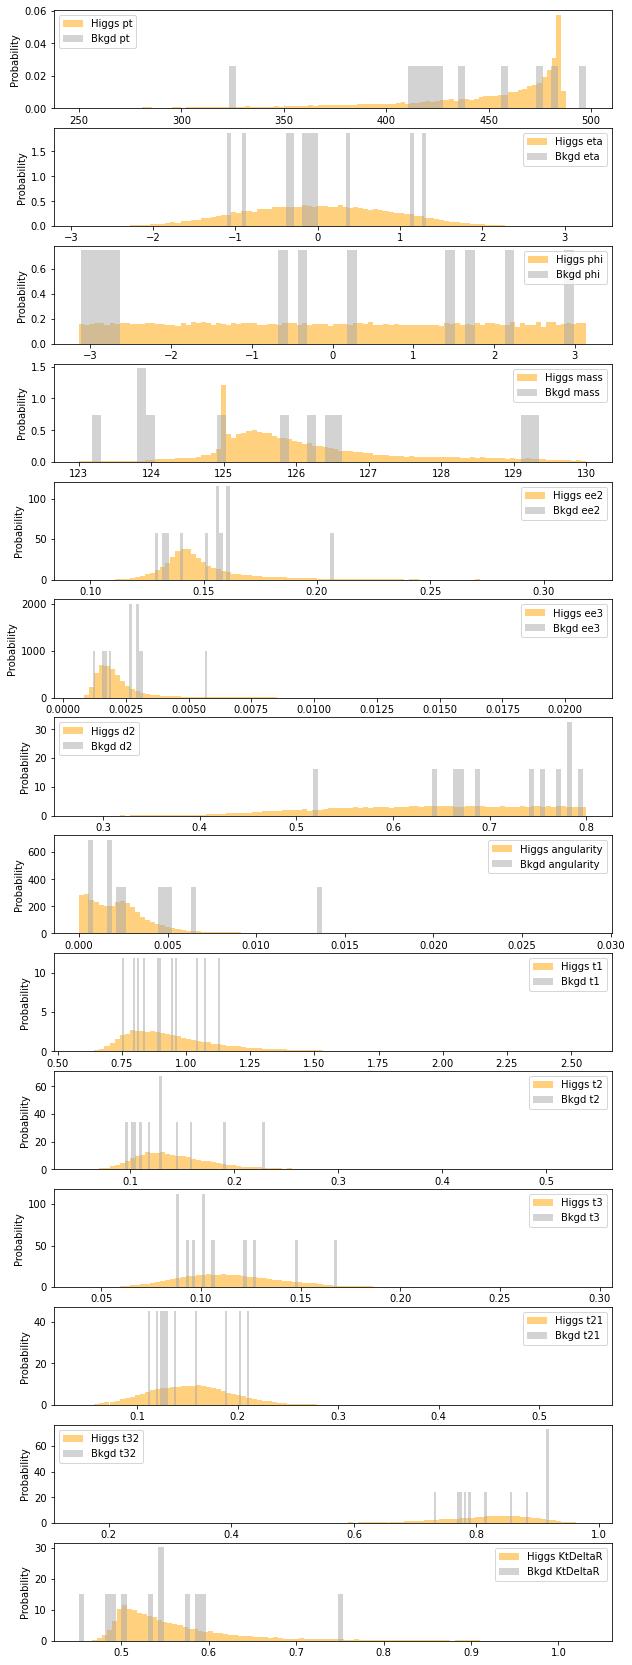

In [124]:
fig,axes=plt.subplots(len(higgs_cuts.columns),figsize=(10,30))
cols=higgs_cuts.columns
for i in range (len(axes)):
    axes[i].hist(higgs_cuts[higgs_cuts.columns[i]],color="orange",alpha=0.5,label=(f"Higgs {cols[i]}"),density=True,bins=100)
    axes[i].hist(bkgd_cuts[bkgd_cuts.columns[i]],color="darkgray",alpha=0.5,label=(f"Bkgd {cols[i]}"),density=True,bins=50)
    axes[i].set_ylabel("Probability")
    axes[i].legend()
    plt.tight_layout

In [125]:
KtDeltaR_ranges=[[0.5,0.7],[0.5,0.75],[0.5,0.8],[0.4,0.8],[0.4,0.88],[0.4,0.9],[0.3,0.8],[0.3,1],[0.46,0.75]]
sigs_KtDeltaR=[]
for i in range (len(KtDeltaR_ranges)):
    higgs_cut=higgs_cuts.query(f'{KtDeltaR_ranges[i][1]}>KtDeltaR>{KtDeltaR_ranges[i][0]}') #higgs bw bounds
    bkgd_cut=bkgd_cuts.query(f'{KtDeltaR_ranges[i][1]}>KtDeltaR>{KtDeltaR_ranges[i][0]}')   #bkgs bw bounds
    significance=(len(higgs_cut)*yield_higgs/len(higgs))/(sqrt(len(bkgd_cut)*yield_bkgd/len(higgs))) 
    sigs_KtDeltaR.append(significance)
print( "KtDeltaR range",KtDeltaR_ranges[np.argmax(sigs_KtDeltaR)], " give maximum significance = ",max(sigs_KtDeltaR))

KtDeltaR range [0.46, 0.75]  give maximum significance =  18.252277544338284


KtDeltaR range [0.5,0.75] increases significance to 18.25. 

In [126]:
t21_ranges=[[0.16,0.25],[0.15,0.28],[0.14,0.31],[0.13,0.35],[0.12,0.5],[0.13,0.5],[0.11,0.36],[0,0.37],[0,0.38],[0,0.39]]
sigs_t21=[]
for i in range (len(t21_ranges)):
    higgs_cut=higgs_cuts.query(f'{t21_ranges[i][1]}>t21>{t21_ranges[i][0]}') #higgs bw bounds
    bkgd_cut=bkgd_cuts.query(f'{t21_ranges[i][1]}>t21>{t21_ranges[i][0]}')   #bkgs bw bounds
    significance=(len(higgs_cut)*yield_higgs/len(higgs))/(sqrt(len(bkgd_cut)*yield_bkgd/len(higgs))) 
    sigs_t21.append(significance)
print( "t21 range",t21_ranges[np.argmax(sigs_t21)], " give maximum significance = ",max(sigs_t21))

t21 range [0.13, 0.5]  give maximum significance =  17.823


In [127]:
higgs_final=higgs_cuts.query(f"({0.75}>KtDeltaR>{0.46})")
bkgd_final=bkgd_cuts.query(f"({0.75}>KtDeltaR>{0.46})")

In [128]:
significance_final=(len(higgs_final)*yield_higgs/len(higgs))/(sqrt(len(bkgd_final)*yield_bkgd/len(higgs)))
significance_final 

18.252277544338284

--

My significance rose from 0.7 to 18.25 .<br>
My partner's significance rose from  0.14 to 0.53 .

## 5)  Bonus

Top two features on raw df : mass and d2.

In [214]:
qcd_file = pd.read_pickle(r'Data/qcd_100000_pt_250_500.pkl')
bkgd_qcd=pd.DataFrame(qcd_file, columns=['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1', 't2', 't3', 't21', 't32', 'KtDeltaR'])
signal_file = pd.read_pickle(r'Data/higgs_100000_pt_250_500.pkl')
higgs=pd.DataFrame(signal_file, columns=['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1', 't2', 't3', 't21', 't32', 'KtDeltaR'])

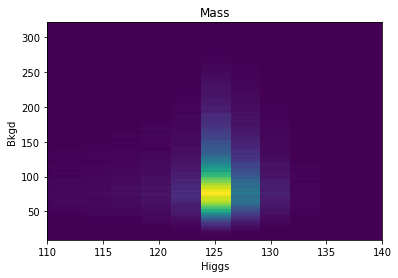

In [219]:
plt.hist2d(higgs["mass"],bkgd_qcd["mass"],bins=[50,100])
plt.xlabel("Higgs");plt.ylabel("Bkgd")
plt.title("Mass")
plt.xlim(110,140)
plt.show()  

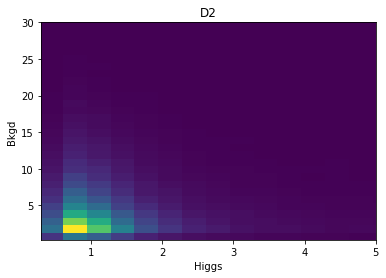

In [231]:
plt.hist2d(higgs["d2"],bkgd_qcd["d2"],bins=100)
plt.xlabel("Higgs");plt.ylabel("Bkgd")
plt.title("D2")
plt.xlim(0.3,5)
plt.ylim(0.3,30)
plt.show()

In [258]:
slope=-(1)/(4)
slope

-0.25

A horizontal cut on mass and a left diagonal cut on D2 can be performed to obtain better significance. <br>
Mass cut at: [123,130] <br>
Left Diagonal Cut : slope = -0.25

In [256]:
bkgd_2d_cut=bkgd_qcd.query(f"({130}>mass>{123}) and ({1}>d2>{0})")
higgs_2d_cut=higgs.query(f"({130}>mass>{123}) and ({4}>d2>{0})")

In [257]:
significance=(len(higgs_2d_cut)*yield_higgs/len(higgs))/(sqrt(len(bkgd_2d_cut)*yield_bkgd/len(higgs))) 
significance

23.051351379402174

Yes, a 2D cut gives a better significance. 

# LAB 8 

#### 1) High Luminosity Data

>For each feature of your event selection, plot the observed data overlapped with expected signal and background (normalized to observed yields) with/without event selection. <br>
>Evaluate observed significance and compare your results to expectation.

In lab 7, we determind the optimal cuts to be the following: <br>
Mass: [123,130] <br>
KtDeltaR: [0.46, 0.75] <br>
D2: [0, 0.8] <br>

In [133]:
data_hl = pd.read_hdf("Data/data_highLumi_pt_250_500.h5")

In [134]:
higgs=pd.DataFrame(signal_file, columns=['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1', 't2', 't3', 't21', 't32', 'KtDeltaR'])
bkgd=pd.DataFrame(qcd_file, columns=['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1', 't2', 't3', 't21', 't32', 'KtDeltaR'])

In [135]:
higgs_final=higgs.query(f"({130}>mass>{123}) and ({0.75}>KtDeltaR>{0.46})and ({0.8}>d2>{0})")
bkgd_final=bkgd.query(f"({130}>mass>{123}) and ({0.75}>KtDeltaR>{0.46}) and ({0.8}>d2>{0})")
data_hl_final=data_hl.query(f"({130}>mass>{123}) and ({0.75}>KtDeltaR>{0.46}) and ({0.8}>d2>{0})")

Checking significance:

In [136]:
((len(higgs_final)*100)/len(higgs))/sqrt((len(bkgd_final)*20000)/len(higgs))

18.252277544338284

This matches what I got in Lab 7. Thus, cuts are consistent. 

In [137]:
len(data_hl_final)

60

### Normalized Distibution

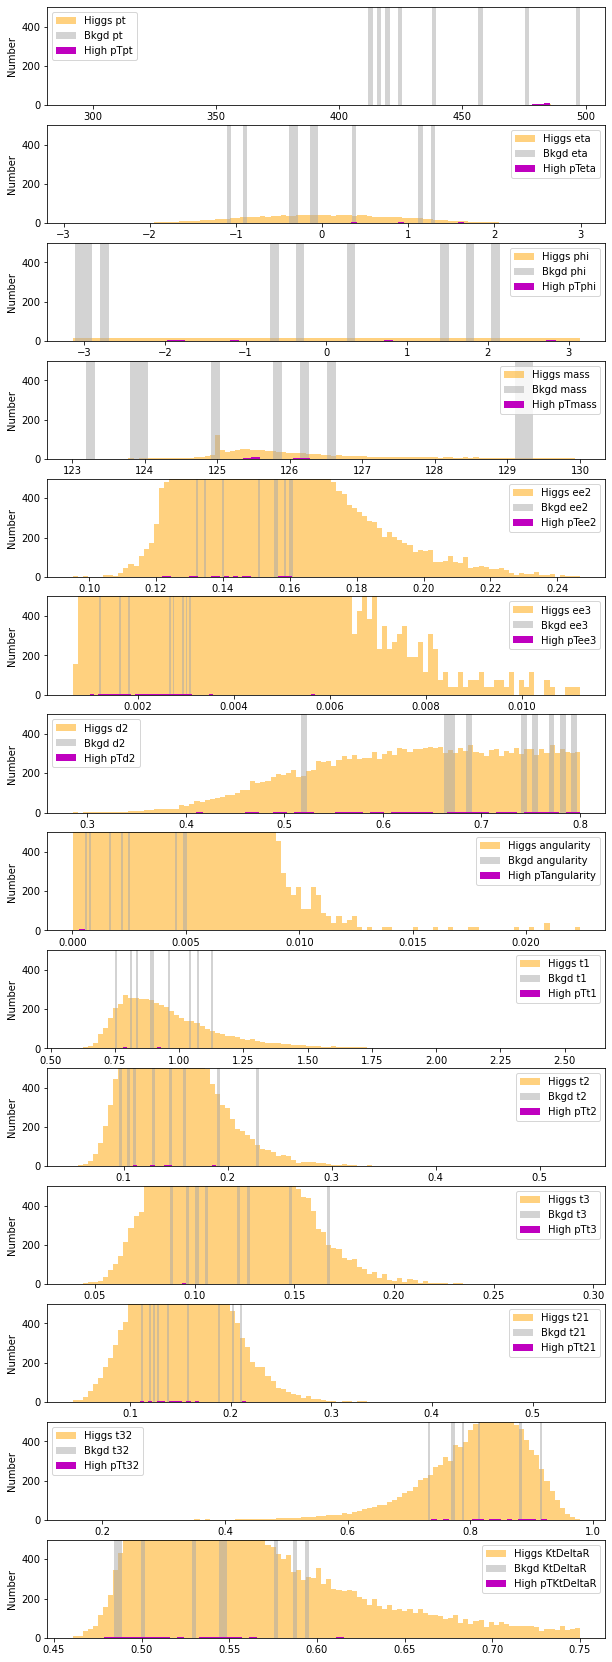

In [138]:
fig,axes=plt.subplots(len(higgs_final.columns),figsize=(10,30))
cols=higgs_final.columns
for i in range (len(axes)):
    hq,bq,_2=axes[i].hist(higgs_final[higgs_final.columns[i]],color="orange",alpha=0.5,label=(f"Higgs {cols[i]}"),density=True,bins=100)
    for r2 in _2:
        r2.set_height(r2.get_height()*yield_higgs) 
    
    hq,bq,_2=axes[i].hist(bkgd_final[bkgd_final.columns[i]],color="darkgray",alpha=0.5,label=(f"Bkgd {cols[i]}"),density=True,bins=50)
    for r2 in _2:
        r2.set_height(r2.get_height()*yield_bkgd) 
    
    axes[i].hist(data_hl_final[data_hl_final.columns[i]],bins=55,color="m",label=(f"High pT{data_hl_final.columns[i]}"))
    axes[i].set_ylabel("Number")
    axes[i].set_ylim(0,500)
    axes[i].legend()
    plt.tight_layout

#### Density Distribution

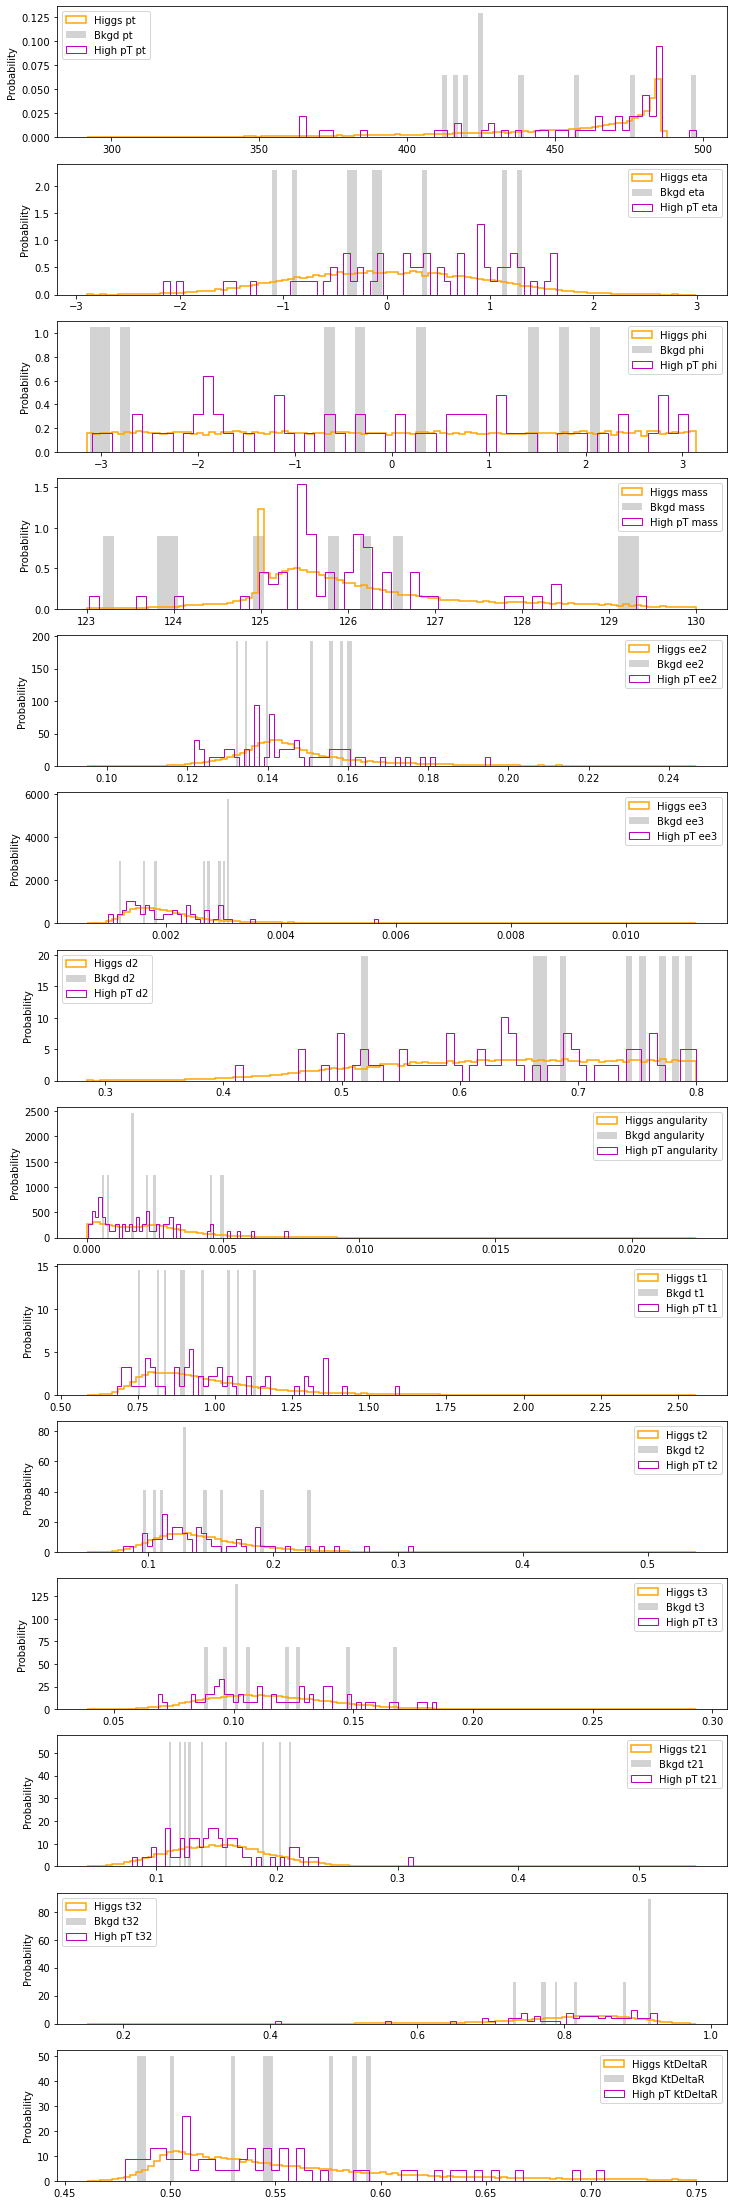

In [139]:
fig,axes=plt.subplots(len(higgs_final.columns),figsize=(12,40))
cols=higgs_final.columns
for i in range (len(axes)):
    hq,bq,_2=axes[i].hist(higgs_final[higgs_final.columns[i]],color="orange",lw=1.5,label=(f"Higgs {cols[i]}"),density=True,histtype="step",bins=100)
    hq,bq,_2=axes[i].hist(bkgd_final[bkgd_final.columns[i]],color="darkgray",alpha=0.5,label=(f"Bkgd {cols[i]}"),density=True,bins=50)
    axes[i].hist(data_hl_final[data_hl_final.columns[i]],bins=59,color="m",label=(f"High pT {data_hl_final.columns[i]}"),histtype="step",density=True)
    
    axes[i].set_ylabel("Probability")
    axes[i].legend()
    plt.tight_layout

### Without any cuts 

##### Normalized

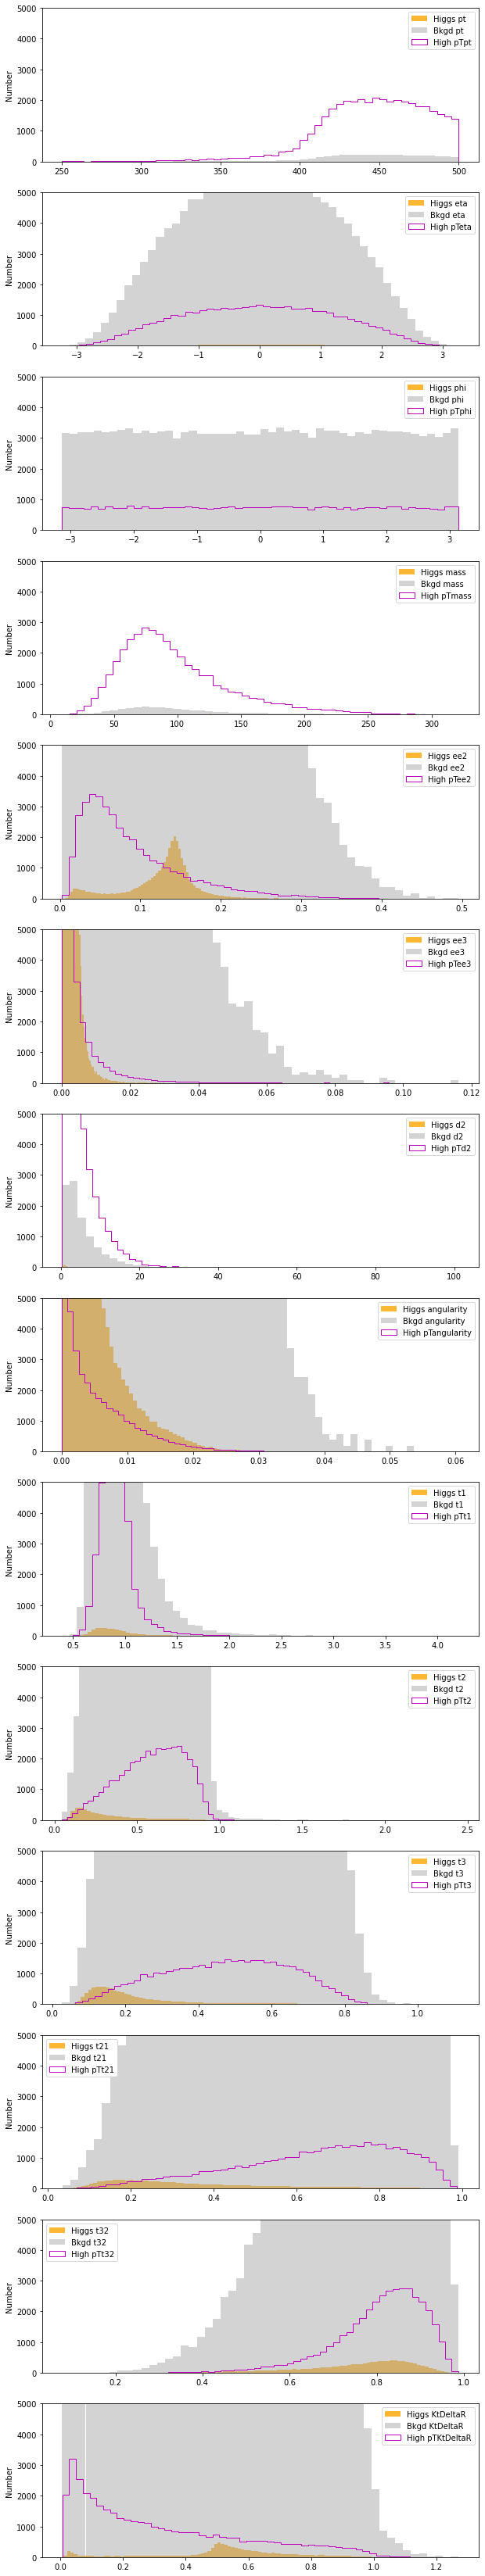

In [140]:
fig,axes=plt.subplots(len(higgs_final.columns),figsize=(10,60))
cols=higgs_final.columns
for i in range (len(axes)):
    hq,bq,_2=axes[i].hist(higgs[higgs.columns[i]],color="orange",alpha=0.8,label=(f"Higgs {cols[i]}"),density=True,bins=100)
    for r2 in _2:
        r2.set_height(r2.get_height()*yield_higgs) 
    
    hq,bq,_2=axes[i].hist(bkgd[bkgd.columns[i]],color="darkgray",alpha=0.5,label=(f"Bkgd {cols[i]}"),density=True,bins=50)
    for r2 in _2:
        r2.set_height(r2.get_height()*yield_bkgd) 
    
    axes[i].hist(data_hl[data_hl.columns[i]],bins=55,color="m",histtype="step",label=(f"High pT{data_hl_final.columns[i]}"))
    axes[i].set_ylabel("Number")
    axes[i].set_ylim(0,5000)
    axes[i].legend()
    plt.tight_layout

##### Density Plots

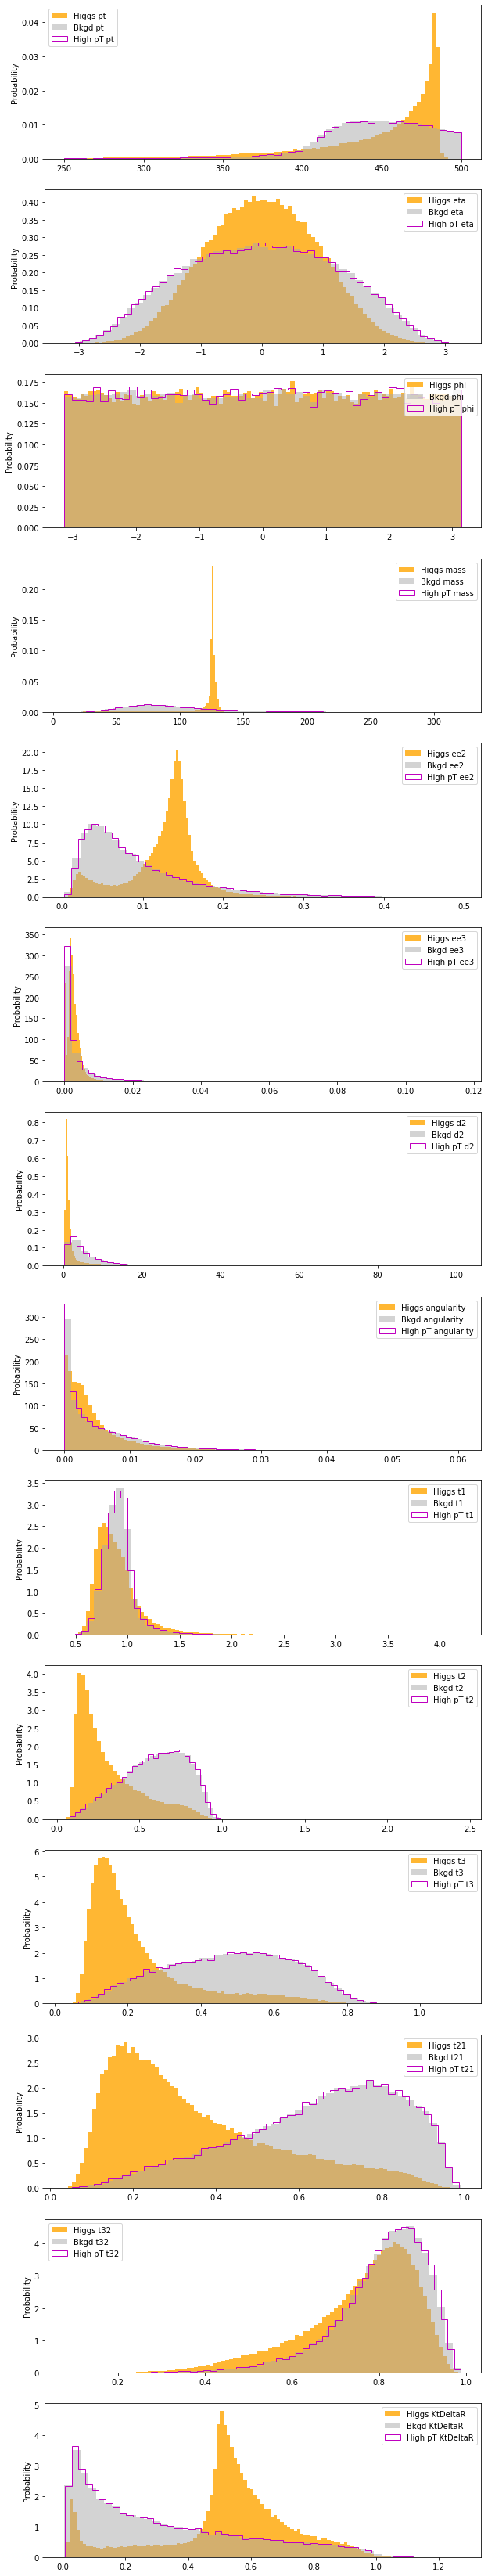

In [141]:
fig,axes=plt.subplots(len(higgs_final.columns),figsize=(10,60))
cols=higgs.columns
for i in range (len(axes)):
    hq,bq,_2=axes[i].hist(higgs[higgs.columns[i]],color="orange",alpha=0.8,label=(f"Higgs {cols[i]}"),density=True,bins=100)
    hq,bq,_2=axes[i].hist(bkgd[bkgd.columns[i]],color="darkgray",alpha=0.5,label=(f"Bkgd {cols[i]}"),density=True,bins=50)
    axes[i].hist(data_hl[data_hl.columns[i]],bins=55,color="m",histtype="step",label=(f"High pT {data_hl_final.columns[i]}"),density=True)
   
    axes[i].set_ylabel("Probability")
    axes[i].legend()
    plt.tight_layout

In [142]:
sig_obs=len(data_hl_final)                        /sqrt((len(bkgd_final)*yield_bkgd)/len(higgs))
sig_exp=((len(higgs_final)*yield_higgs)/len(higgs))/sqrt((len(bkgd_cut)*yield_bkgd)/len(higgs))
sig_obs,sig_exp

(44.721359549995796, 16.50980623199987)

Fo high luminosity data, the observed significance of 44.72 is much higher than the expected significance of 18.25 .

### Low Luminosity 

In [143]:
data_ll = pd.read_hdf("Data/data_lowLumi_pt_250_500.h5")
data_ll_final=data_ll.query(f"({130}>mass>{123}) and ({0.75}>KtDeltaR>{0.46}) and ({0.8}>d2>{0})")
len(data_ll_final)

5

#### With Cuts
##### Normalized Plots

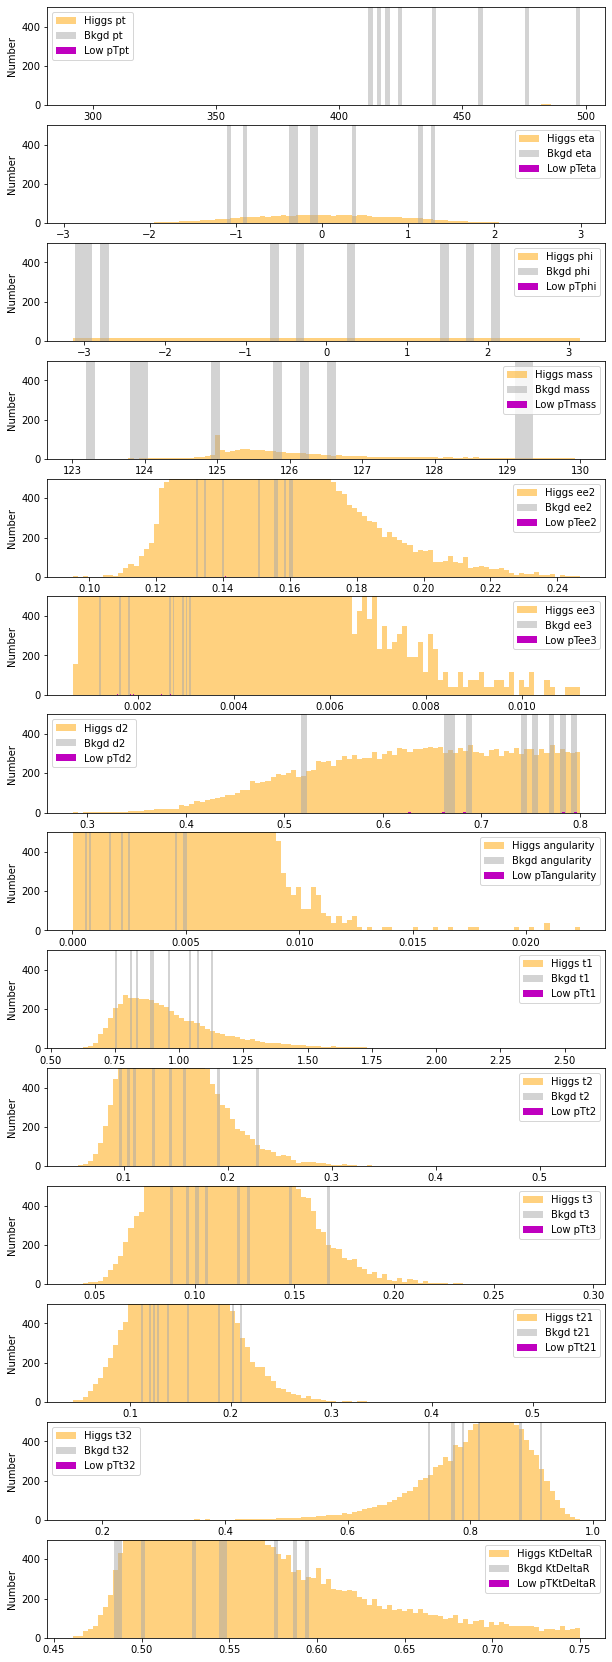

In [144]:
fig,axes=plt.subplots(len(higgs_final.columns),figsize=(10,30))
cols=higgs_final.columns
for i in range (len(axes)):
    hq,bq,_2=axes[i].hist(higgs_final[higgs_final.columns[i]],color="orange",alpha=0.5,label=(f"Higgs {cols[i]}"),density=True,bins=100)
    for r2 in _2:
        r2.set_height(r2.get_height()*yield_higgs) 
    
    hq,bq,_2=axes[i].hist(bkgd_final[bkgd_final.columns[i]],color="darkgray",alpha=0.5,label=(f"Bkgd {cols[i]}"),density=True,bins=50)
    for r2 in _2:
        r2.set_height(r2.get_height()*yield_bkgd) 
    
    axes[i].hist(data_ll_final[data_ll_final.columns[i]],bins=55,color="m",label=(f"Low pT{data_hl_final.columns[i]}"))
    axes[i].set_ylabel("Number")
    axes[i].set_ylim(0,500)
    axes[i].legend()
    plt.tight_layout

In the above graphs, it is almost impossible to see the low luminosity data.This is because of the height differences after normalization. 

Below, I will plot the density plots to look at the shapes of the distribution. 

##### Density Plots

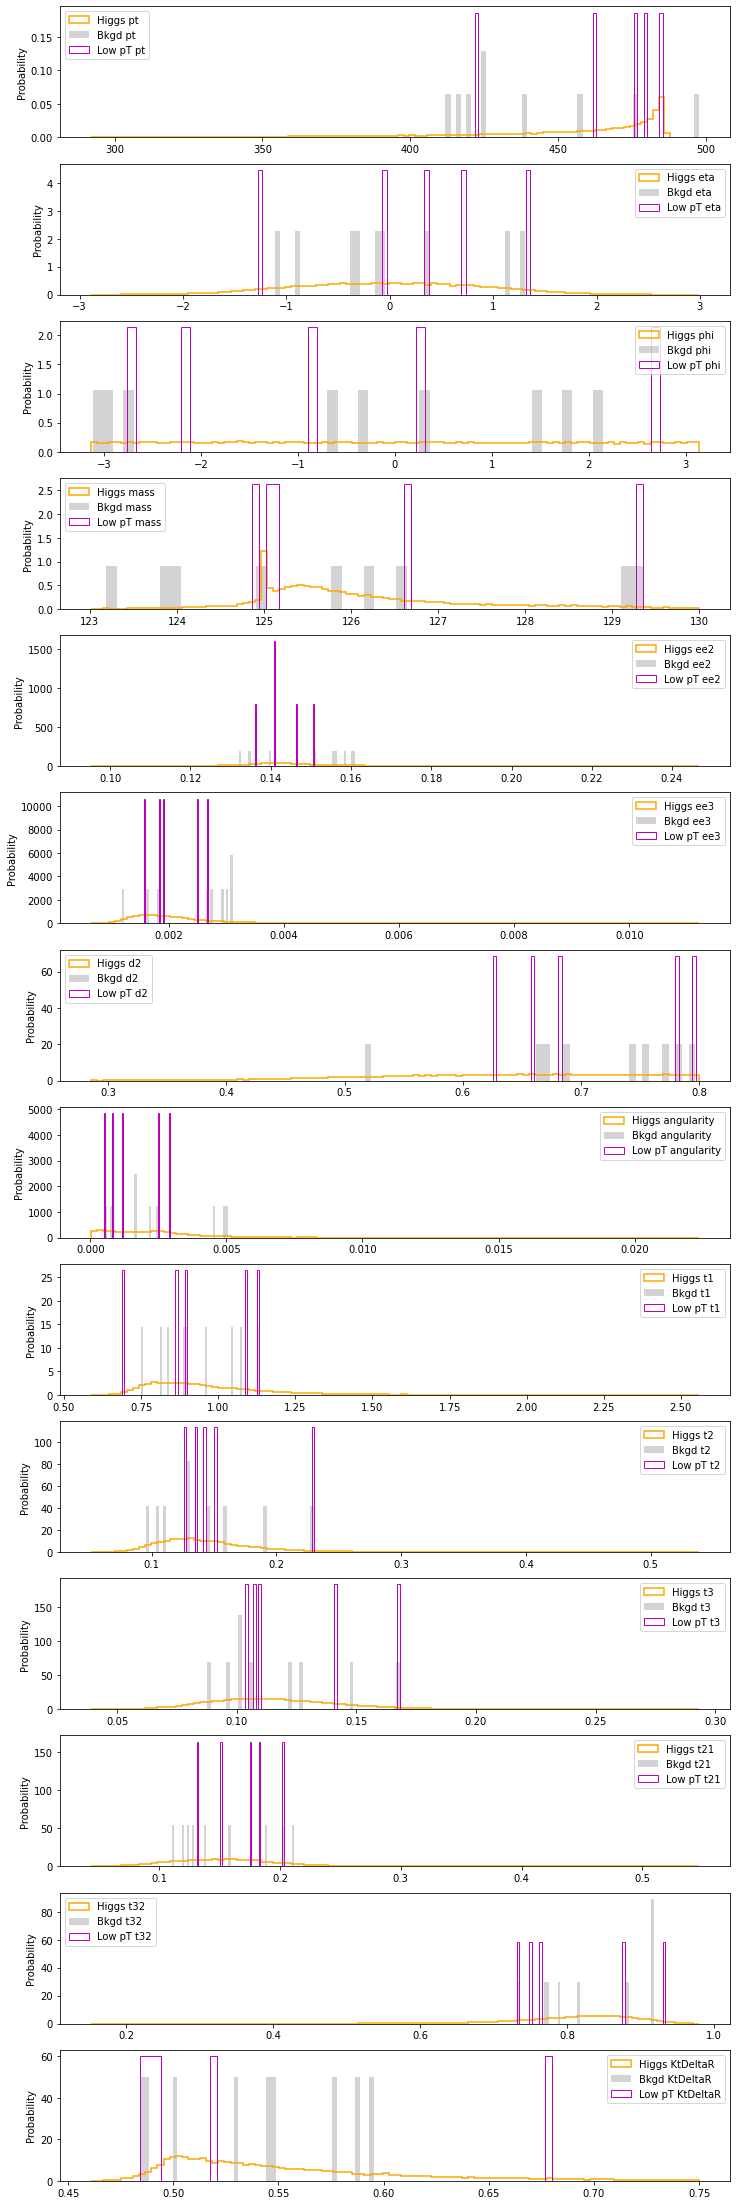

In [145]:
fig,axes=plt.subplots(len(higgs_final.columns),figsize=(12,40))
cols=higgs_final.columns
for i in range (len(axes)):
    hq,bq,_2=axes[i].hist(higgs_final[higgs_final.columns[i]],color="orange",lw=1.5,label=(f"Higgs {cols[i]}"),density=True,histtype="step",bins=100)
    hq,bq,_2=axes[i].hist(bkgd_final[bkgd_final.columns[i]],color="darkgray",alpha=0.5,label=(f"Bkgd {cols[i]}"),density=True,bins=50)
    axes[i].hist(data_ll_final[data_ll_final.columns[i]],bins=59,color="m",label=(f"Low pT {data_hl_final.columns[i]}"),histtype="step",density=True)
    
    axes[i].set_ylabel("Probability")
    axes[i].legend()
    plt.tight_layout

#### Without Cuts

##### Normalized

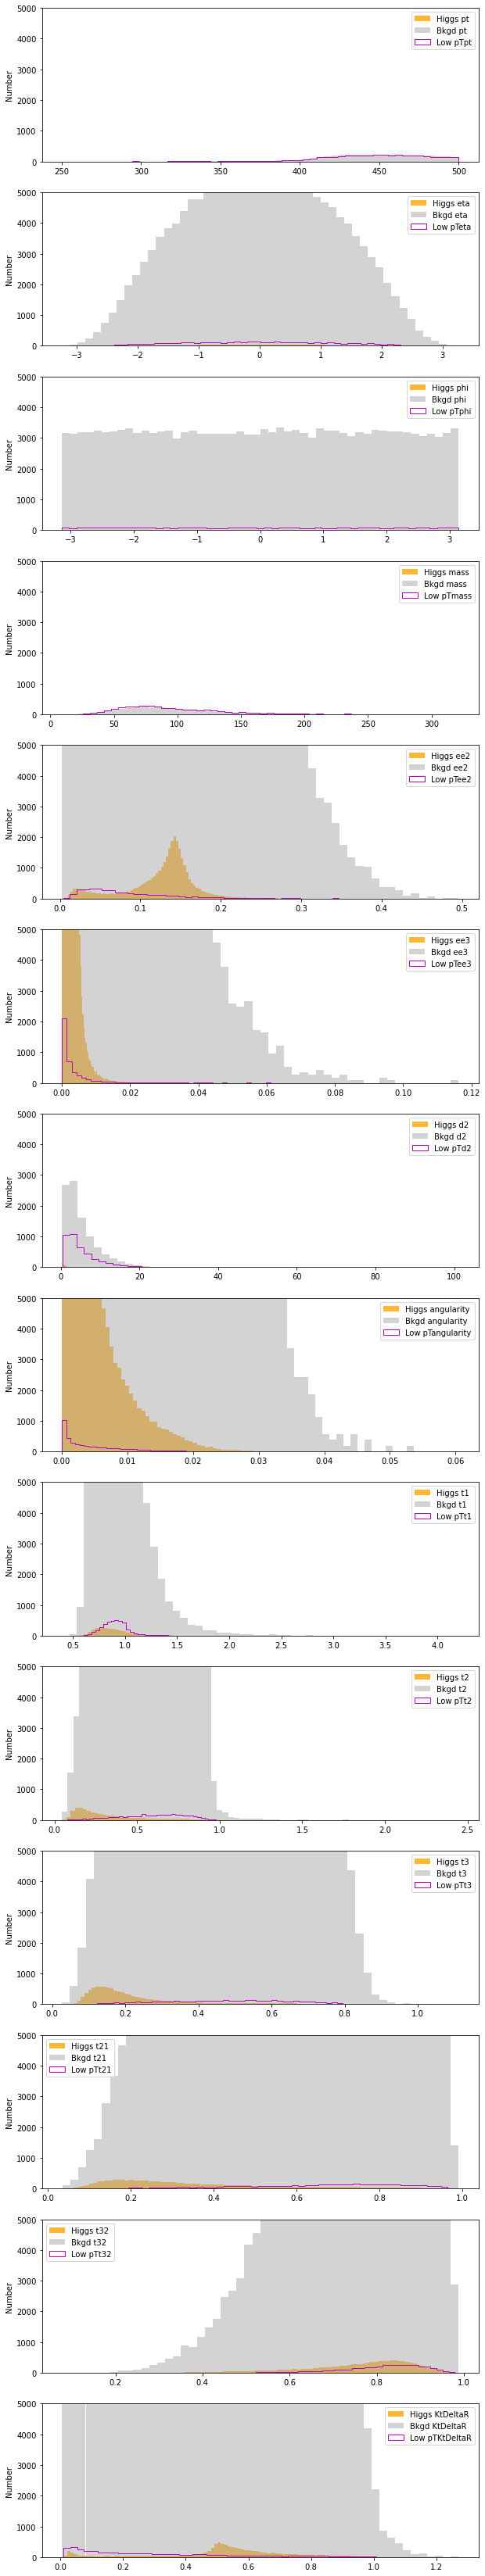

In [146]:
fig,axes=plt.subplots(len(higgs_final.columns),figsize=(10,60))
cols=higgs_final.columns
for i in range (len(axes)):
    hq,bq,_2=axes[i].hist(higgs[higgs.columns[i]],color="orange",alpha=0.8,label=(f"Higgs {cols[i]}"),density=True,bins=100)
    for r2 in _2:
        r2.set_height(r2.get_height()*yield_higgs) 
    
    hq,bq,_2=axes[i].hist(bkgd[bkgd.columns[i]],color="darkgray",alpha=0.5,label=(f"Bkgd {cols[i]}"),density=True,bins=50)
    for r2 in _2:
        r2.set_height(r2.get_height()*yield_bkgd) 
    
    axes[i].hist(data_ll[data_ll.columns[i]],bins=55,color="m",histtype="step",label=(f"Low pT{data_hl_final.columns[i]}"))
    axes[i].set_ylabel("Number")
    axes[i].set_ylim(0,5000)
    axes[i].legend()
    plt.tight_layout

##### Density Plots

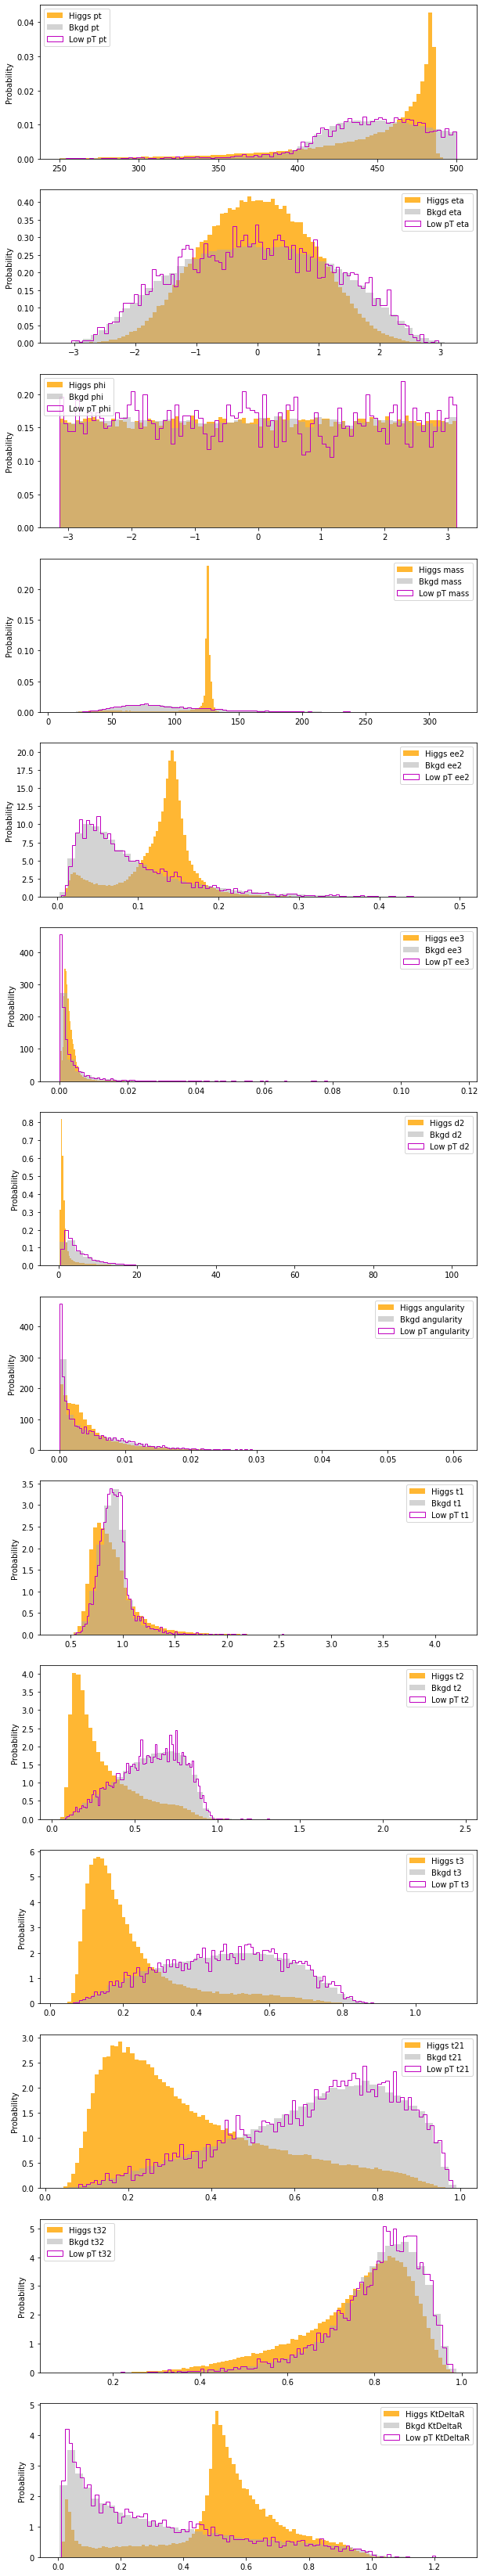

In [147]:
fig,axes=plt.subplots(len(higgs_final.columns),figsize=(10,60))
cols=higgs.columns
for i in range (len(axes)):
    hq,bq,_2=axes[i].hist(higgs[higgs.columns[i]],color="orange",alpha=0.8,label=(f"Higgs {cols[i]}"),density=True,bins=100)
    hq,bq,_2=axes[i].hist(bkgd[bkgd.columns[i]],color="darkgray",alpha=0.5,label=(f"Bkgd {cols[i]}"),density=True,bins=50)
    axes[i].hist(data_ll[data_ll.columns[i]],bins=100,color="m",histtype="step",label=(f"Low pT {data_hl_final.columns[i]}"),density=True)
   
    axes[i].set_ylabel("Probability")
    axes[i].legend()
    plt.tight_layout

In [152]:
sig_obs=len(data_ll_final)                  /sqrt((len(bkgd_final)*20000)/len(higgs))
sig_exp=((len(higgs_final)*100)/len(higgs))/sqrt((len(bkgd_final)*20000)/len(higgs))
sig_obs,sig_exp

(3.7267799624996494, 18.252277544338284)

Much Lower Significance. This could be because the low luminosity data follows the background (in shape) very closely. Thus, a very large part of the data is thrown out. This is confirmed by the lengths of the points. In the case of high luminosity, 60 data points are retained whereas in the case of low luminosity only 5 data points are retained after cuts. 

-----------------------
### 3) 

##### 95% Confidence Level of signal yields

<u> Question </u>
In the low luminosity data, the observed significance is less than 5 σ . We will calculate the 95% confidence level upper limit of signal yield. <br>
a) Evaluate the expected 95% confidence level upper limit. <br>
b) Evaluate the observed 95% confidence level upper limit <br>
c) Compare expectation to observation. Comment on your finding. <br>



<u> Answer </u>

I will find the CL using the Null Hypothesis: Assuming all data is background and any signal is excess. I will integrate the signal until I reach a 95% probability. 

In [149]:
from scipy.stats import poisson,norm

In [150]:
N_bkgd,N_signal,N_lowlumi=len(bkgd_final),len(higgs_final),len(data_ll_final)

In [151]:
N_bkgd,N_signal,N_lowlumi

(9, 24488, 5)

In [51]:
size=1000000
data=poisson.rvs(N_bkgd,size = size)

#### Throwing a uniform signal 

In [169]:
signal_exp=N_signal
signal_obs=N_lowlumi
bkgd=poisson.rvs(N_bkgd,size = size)

In [168]:
N_signal

24488

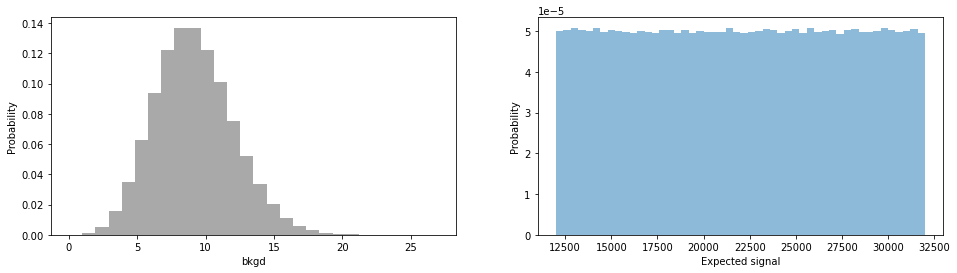

In [195]:
fig, (ax,ax2) = plt.subplots(1, 2,figsize=(16,4))
ax.hist(bkgd,28, density=True,color="darkgray")
ax.set_xlabel("bkgd")
ax.set_ylabel("Probability")

ax2.hist(signal_2exp,bins=50,alpha=0.5,density=True)
ax2.set_xlabel("Expected signal")
ax2.set_ylabel("Probability")

plt.show()


In [203]:
signal_2exp=np.random.uniform(12000,32000,1000000)
signal_2obs=np.random.uniform(0,10,1000000)
data=bkgd+signal_2exp

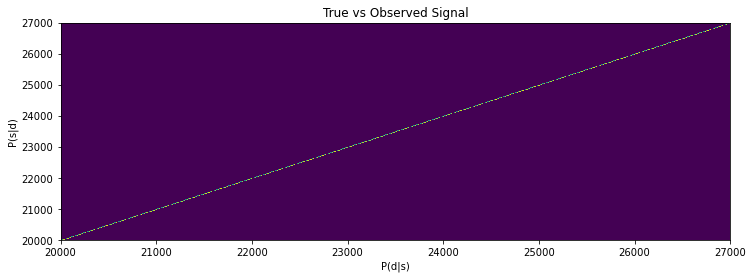

In [188]:
plt.figure(figsize=(12,4))
dataedges=np.linspace(20000,27000,500)
signaledges=np.linspace(20000,27000,500)
datacenters = (dataedges[:-1] + dataedges[1:]) / 2
signalcenters = (signaledges[:-1] + signaledges[1:]) / 2

h,x_edges,y_edges,image=plt.hist2d(data,signal_2exp,bins=[dataedges,signaledges],density=True)
plt.xlabel("P(d|s)")
plt.ylabel("P(s|d)")
#plt.xlim(0,800)
#plt.ylim(0,590)
plt.title("True vs Observed Signal")
plt.show()

In [68]:
N_signal,N_bkgd

(24488, 9)

#### Taking a vertical slice at N_bkgd

In [176]:
def find_nearest(array, value):
    array = array
    idx = (np.abs(array - value)).argmin()
    return [idx,array[idx]]

285 24005.010020040078


(23800.0, 24100.0)

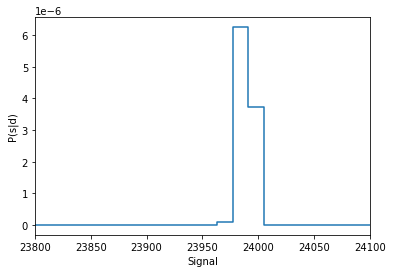

In [191]:
val=24000
i,s=find_nearest(datacenters,val)
print (i,s)
v_slice=h[i]
plt.step(signalcenters,v_slice)
plt.xlabel("Signal")
plt.ylabel("P(s|d)")
plt.xlim(23800,24100)

In [204]:
df=pd.DataFrame(data_2,columns=["data"])
df["signal"]=signal_2exp
df["bkgd"]=bkgd
df["lowlumi"]=signal_2obs
df.head(3)

,data,signal,bkgd,lowlumi
0,27465.780332,19313.347570,12,6.812830
1,22726.904599,25127.268180,12,0.347589
2,26617.890456,21099.997812,12,7.840403


In [205]:
observed= [27400,27450] 
d=df.query(f'{observed[0]}< data <{observed[1]}')
h,b,p=plt.hist(d["signal"],bins=30,density=True)
plt.close()

In [207]:
percent_to_sigma=norm.ppf(0.95)
percent_to_sigma

1.6448536269514722

In [209]:
percent=0.95
width=np.diff(b)
bounds=[]
for i in range (len(h/2)):
    if np.sum(h[:i]*width[:i])>=percent:
        bounds.append(i)
        break
b[bounds]

array([31305.39594854])

In [210]:
data=bkgd+signal_2obs

In [211]:
df=pd.DataFrame(data,columns=["data"])
df["bkgd"]=bkgd
df["lowlumi"]=signal_2obs
df.head(3)

,data,bkgd,lowlumi
0,18.812830,12,6.812830
1,12.347589,12,0.347589
2,19.840403,12,7.840403


In [212]:
observed= [9.5,10.5] 
d=df.query(f'{observed[0]}< data <{observed[1]}')
h,b,p=plt.hist(d["lowlumi"],bins=30,density=True)
plt.close()

In [213]:
percent=0.95
width=np.diff(b)
bounds=[]
for i in range (len(h/2)):
    if np.sum(h[:i]*width[:i])>=percent:
        bounds.append(i)
        break
b[bounds]

array([6.33320069])

Following are th 95% confidence upper limits:<br>
Expected : 31305.40 <br>
Observed : 6.33 <br>

My N_exp is 24k while N_obs= 5 only (most of it is cut out as low luminosity follows the background very closely). Hence, the stark difference in the 95% CL .

---
#### Bonus

### 1 sigma uncertainty. 

In [272]:
sigma_to_prob=norm.cdf(1)
mu=31305
exp_uncert=poisson.ppf(q=sigma_to_prob,mu=31305)
((exp_uncert-mu)/mu)

0.005654048873981792

In [271]:
sigma_to_prob=norm.cdf(1)
mu=6
obs_uncert=poisson.ppf(q=sigma_to_prob,mu=6)
((obs_uncert-mu)/mu)

0.3333333333333333

1 sigma uncertainty for observed data is much higher. 